# TASK 1: Acquiring the Data
We start first with the FashionMNIST dataset

In [1]:
import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Initialize generator
generator = torch.Generator().manual_seed(seed)

# For Fashion MNIST
trainset_fashion = datasets.FashionMNIST('./data', download=True, train=True, transform=transforms.ToTensor())
trainloader_fashion = DataLoader(trainset_fashion, shuffle=True, generator=generator)

testset_fashion = datasets.FashionMNIST('./data', download=True, train=False, transform=transforms.ToTensor())
testloader_fashion = DataLoader(testset_fashion)

# For CIFAR-10
trainset_cifar = datasets.CIFAR10('./data', download=True, train=True, transform=transforms.ToTensor())
trainloader_cifar = DataLoader(trainset_cifar, shuffle=True, generator=generator)

testset_cifar = datasets.CIFAR10('./data', download=True, train=False, transform=transforms.ToTensor())
testloader_cifar = DataLoader(testset_cifar)

Files already downloaded and verified
Files already downloaded and verified


We then verify the data is correct by using the code from: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
to plot the data

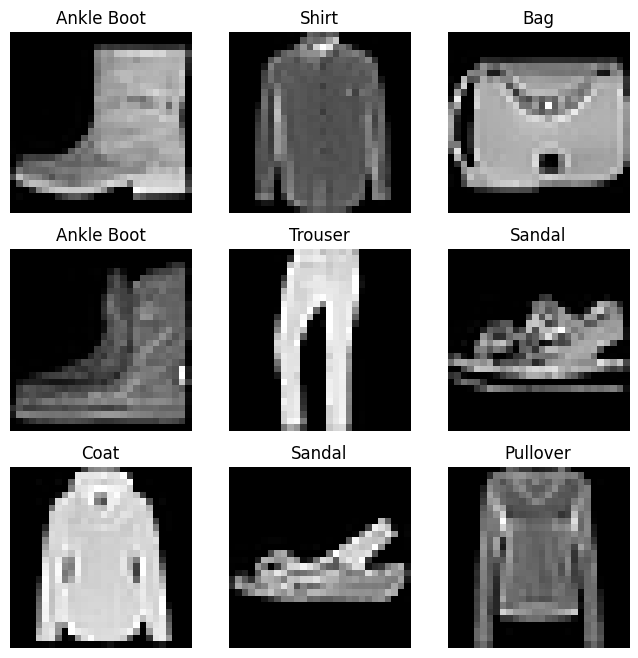

In [2]:

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset_fashion), size=(1,)).item()
    img, label = trainset_fashion[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We then need to vectorize the images to be able to use them for learning.

In [3]:
trainset_fashion_X = trainset_fashion.data.numpy()
trainset_fashion_y = trainset_fashion.targets.numpy()
testset_fashion_X = testset_fashion.data.numpy()
testset_fashion_y = testset_fashion.targets.numpy()
len_img = trainset_fashion_X.shape[1] * trainset_fashion_X.shape[2]
trainset_fashion_X = trainset_fashion_X.reshape(trainset_fashion_X.shape[0], len_img)
testset_fashion_X = testset_fashion_X.reshape(testset_fashion_X.shape[0], len_img)

We do the same with the CIFAR-10 set

In [4]:
trainset_cifar_X = trainset_cifar.data
trainset_cifar_y = trainset_cifar.targets
testset_cifar_X = testset_cifar.data 
testset_cifar_y = testset_cifar.targets 

trainset_cifar_X.shape

(50000, 32, 32, 3)

In [5]:
len_img_cifar = trainset_cifar_X.shape[1] * trainset_cifar_X.shape[2] * trainset_cifar_X.shape[3]
trainset_cifar_X = trainset_cifar_X.reshape((trainset_cifar_X.shape[0], len_img_cifar))
testset_cifar_X = testset_cifar_X.reshape((testset_cifar_X.shape[0], len_img_cifar))

Finally, we normalize the training and test sets. We only consider the mean and std of the training set in normalization to make sure we can generalize to any data

In [6]:
fashion_mean = np.mean(trainset_fashion_X, axis=0)
fashion_std = np.std(trainset_fashion_X, axis=0)
trainset_fashion_X = (trainset_fashion_X - fashion_mean) / fashion_std
testset_fashion_X = (testset_fashion_X - fashion_mean) / fashion_std

In [7]:
cifar_mean = np.mean(trainset_cifar_X, axis=0)
cifar_std = np.std(trainset_cifar_X, axis=0)
trainset_cifar_X = (trainset_cifar_X - cifar_mean) / cifar_std
testset_cifar_X = (testset_cifar_X - cifar_mean) / cifar_std

## Task 2: Implementing MLP Model

The MLP model is created modularly as Nodes for basic operations, such as Multiply, Add, ReLU and Softmax. The nodes are in the node.py module and the mlp implementation is in the mlp.py module

In [8]:
from mlp import MLP 

c:\Users\rsaif\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Task 3: Running Experiments

For our experiments, we have a parameter MAX_ITERS for maximum training iteration. For each model that is significantly different, we will investigate this once. In case we are comparing models, we will evaluate the ideal parameters for the best model and use that for all of our models.

In [9]:
MAX_ITERS = 10000 # Set parameter to allow for quick reconfiguration

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def smooth_plot(data: np.ndarray, window_size: int):
    window = np.ones(window_size) / float(window_size)
    return np.convolve(data, window, mode="valid")

1. Experimenting with Weight Initializations:

In [11]:
# Find optimal training iterations using Xavier initialization
mlp_xavier = MLP("ReLU", 1, 128, len_img, 10, "xavier")
mlp_xavier.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                0.01, batch_size=25, max_iters=5e4)

Finished in 50000


Text(0.5, 1.0, 'Initialization with Xavier')

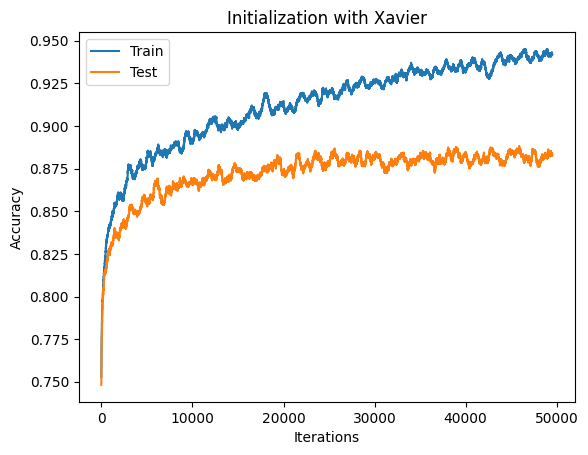

In [12]:
acc_xavier = smooth_plot(mlp_xavier.acc_list, window_size=500)
test_acc_xavier = smooth_plot(mlp_xavier.test_acc_list, window_size=500)
plt.plot(acc_xavier, label="Train")
plt.plot(test_acc_xavier, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Initialization with Xavier")

We can see the training accuracy start to plateau within about 10,000 iterations. Because we still see a small improvement until 20,000 iterations, we will use that for this section

In [13]:
MAX_ITERS = 20000 

In [14]:
# All zeros
mlp_zeros = MLP("ReLU", 1, 128, len_img, 10, "zeros")
mlp_zeros.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
              0.01, batch_size=25, max_iters=MAX_ITERS)
acc_zeros = smooth_plot(mlp_zeros.acc_list, window_size=500)
test_acc_zeros = smooth_plot(mlp_zeros.test_acc_list, window_size=500)
testset_fashion_yh = mlp_zeros.predict(testset_fashion_X)
final_acc_zeros = mlp_zeros.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Initialization with All Zeros')

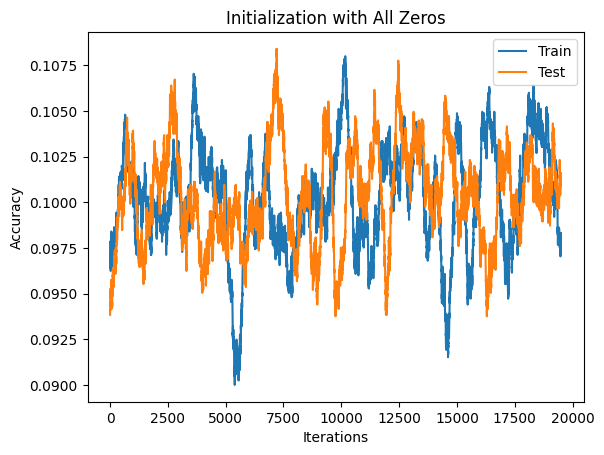

In [15]:
# Plot training and test accuracy
plt.plot(acc_zeros, label="Train")
plt.plot(test_acc_zeros, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Initialization with All Zeros")

In [16]:
# Uniform [-1, 1]
mlp_uniform = MLP("ReLU", 1, 128, len_img, 10, "uniform")
mlp_uniform.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                 0.01, batch_size=25, max_iters=MAX_ITERS)
acc_uniform = smooth_plot(mlp_uniform.acc_list, window_size=50)
test_acc_uniform = smooth_plot(mlp_uniform.test_acc_list, window_size=50)
testset_fashion_yh = mlp_uniform.predict(testset_fashion_X)
final_acc_uniform = mlp_uniform.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Initialization with Uniform [-1, 1]')

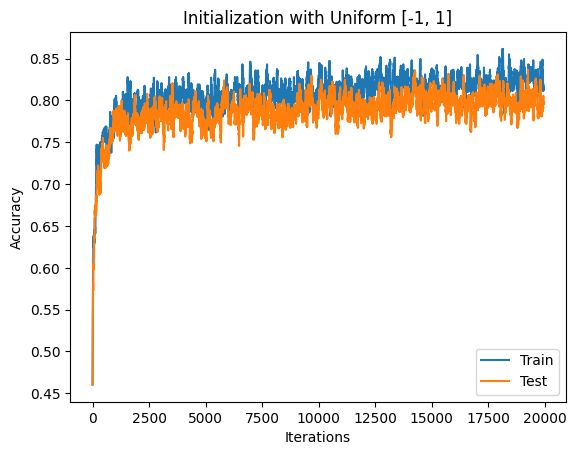

In [17]:
# Plot training and test accuracy
plt.plot(acc_uniform, label="Train")
plt.plot(test_acc_uniform, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Initialization with Uniform [-1, 1]")

In [18]:
# Gaussian N(0, 1)
mlp_gaussian = MLP("ReLU", 1, 128, len_img, 10, "gaussian")
mlp_gaussian.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y, 
                0.01, batch_size=25, max_iters=MAX_ITERS)
acc_gaussian = smooth_plot(mlp_gaussian.acc_list, window_size=50)
test_acc_gaussian = smooth_plot(mlp_gaussian.test_acc_list, window_size=50)
testset_fashion_yh = mlp_gaussian.predict(testset_fashion_X)
final_acc_gaussian = mlp_gaussian.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Initialization with Gaussian N(0, 1)')

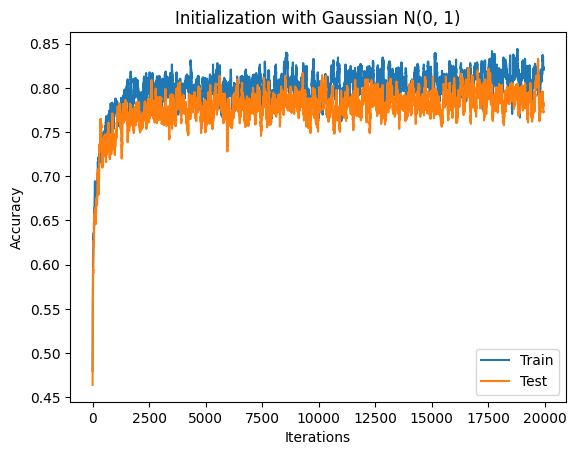

In [19]:
# Plot training and test accuracy
plt.plot(acc_gaussian, label="Train")
plt.plot(test_acc_gaussian, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Initialization with Gaussian N(0, 1)")

In [20]:
# Xavier
mlp_xavier = MLP("ReLU", 1, 128, len_img, 10, "xavier")
mlp_xavier.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                0.01, batch_size=25, max_iters=MAX_ITERS)
acc_xavier = smooth_plot(mlp_xavier.acc_list, window_size=50)
test_acc_xavier = smooth_plot(mlp_xavier.test_acc_list, window_size=50)
testset_fashion_yh = mlp_xavier.predict(testset_fashion_X)
final_acc_xavier = mlp_xavier.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Initialization with Xavier')

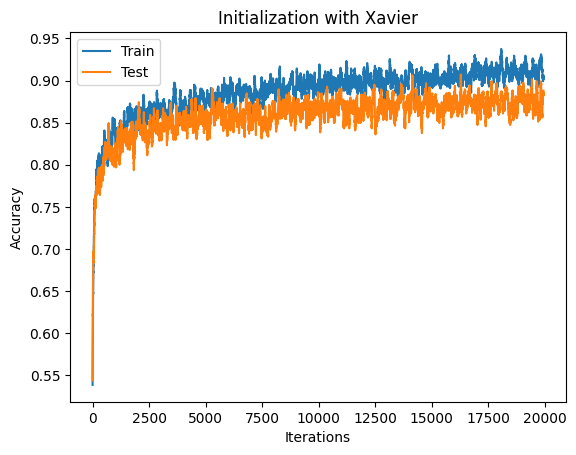

In [21]:
# Plot training and test accuracy
plt.plot(acc_xavier, label="Train")
plt.plot(test_acc_xavier, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Initialization with Xavier")

In [22]:
# Kaiming
mlp_kaiming = MLP("ReLU", 1, 128, len_img, 10, "kaiming")
mlp_kaiming.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                0.01, batch_size=25, max_iters=MAX_ITERS)
acc_kaiming = smooth_plot(mlp_kaiming.acc_list, window_size=50)
test_acc_kaiming = smooth_plot(mlp_kaiming.test_acc_list, window_size=50)
testset_fashion_yh = mlp_kaiming.predict(testset_fashion_X)
final_acc_kaiming = mlp_kaiming.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Initialization with Kaiming')

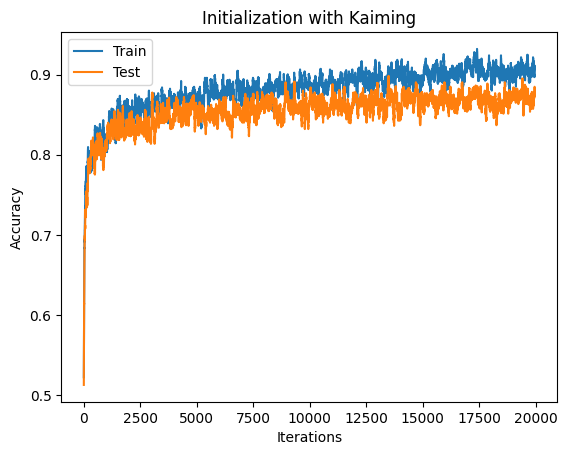

In [23]:
# Plot training and test accuracy
plt.plot(acc_kaiming, label="Train")
plt.plot(test_acc_kaiming, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Initialization with Kaiming")

Text(0.5, 1.0, 'Accuracy on Training Set')

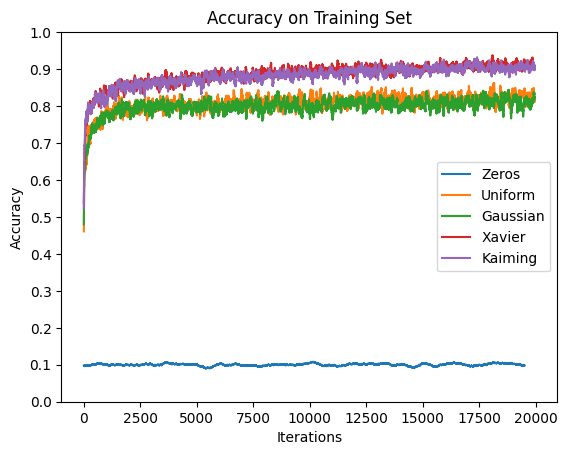

In [24]:
# Plot all of the mlp accuracy curves
plt.plot(acc_zeros, label="Zeros")
plt.plot(acc_uniform, label="Uniform")
plt.plot(acc_gaussian, label="Gaussian")
plt.plot(acc_xavier, label="Xavier")
plt.plot(acc_kaiming, label="Kaiming")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.title("Accuracy on Training Set")

Text(0.5, 1.0, 'Accuracy on Test Set')

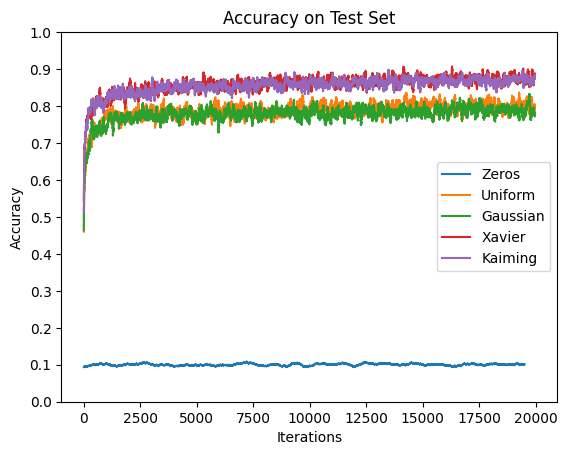

In [25]:
# Plot test accuracy curves
plt.plot(test_acc_zeros, label="Zeros")
plt.plot(test_acc_uniform, label="Uniform")
plt.plot(test_acc_gaussian, label="Gaussian")
plt.plot(test_acc_xavier, label="Xavier")
plt.plot(test_acc_kaiming, label="Kaiming")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.title("Accuracy on Test Set")

In [26]:
# Pandas dataframe for final accuracy
data = {
    "Zeros": [final_acc_zeros],
    "Uniform": [final_acc_uniform],
    "Gaussian": [final_acc_gaussian],
    "Xavier": [final_acc_xavier],
    "Kaiming": [final_acc_kaiming]
}
df = pd.DataFrame(data, index=["Final Testset Accuracy"])
df

,Zeros,Uniform,Gaussian,Xavier,Kaiming
Final Testset Accuracy,0.1,0.8136,0.8044,0.8742,0.8707


2. We now use 3 different MLP models- one with no hidden layers, another with a single hidden layer with 128 units and lastly one with two hidden layers and 128 units per hidden layer. From the previous section, we note Kaiming and Xavier initialization give us the best results, so we will perform our experiments with Kaiming initialization.

In [27]:
# No hidden layers
mlp_no_hidden = MLP("ReLU", 0, 0, len_img, 10, "kaiming")
mlp_no_hidden.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                  0.01, batch_size=25, max_iters=MAX_ITERS)
acc_no_hidden = smooth_plot(mlp_no_hidden.acc_list, window_size=50)
test_acc_no_hidden = smooth_plot(mlp_no_hidden.test_acc_list, window_size=50)
testset_fashion_yh = mlp_no_hidden.predict(testset_fashion_X)
final_acc_no_hidden = mlp_no_hidden.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'No hidden layers')

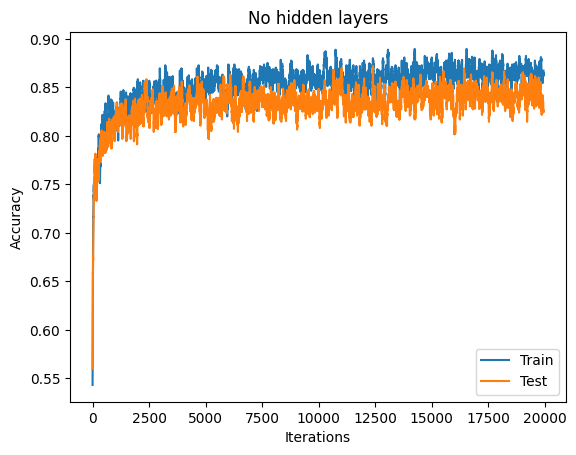

In [28]:
# Plot the accuracy curves
plt.plot(acc_no_hidden, label="Train")
plt.plot(test_acc_no_hidden, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("No hidden layers")

In [29]:
# One hidden layer with 128 neurons
mlp_one_hidden = MLP("ReLU", 1, 128, len_img, 10, "kaiming")
mlp_one_hidden.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                   0.01, batch_size=25, max_iters=MAX_ITERS)
acc_one_hidden = smooth_plot(mlp_one_hidden.acc_list, window_size=50)
test_acc_one_hidden = smooth_plot(mlp_one_hidden.test_acc_list, window_size=50)
testset_fashion_yh = mlp_one_hidden.predict(testset_fashion_X)
final_acc_one_hidden = mlp_one_hidden.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'One hidden layer with 128 units')

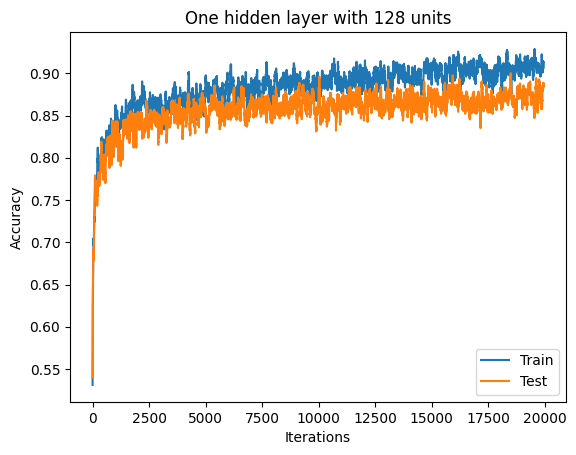

In [30]:
# Plot the accuracy curves
plt.plot(acc_one_hidden, label="Train")
plt.plot(test_acc_one_hidden, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("One hidden layer with 128 units")

In [31]:
# Two hidden layers with 128 neurons
mlp_two_hidden = MLP("ReLU", 2, 128, len_img, 10, "kaiming")
mlp_two_hidden.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                0.01, batch_size=25, max_iters=MAX_ITERS)
acc_two_hidden = smooth_plot(mlp_two_hidden.acc_list, window_size=50)
test_acc_two_hidden = smooth_plot(mlp_two_hidden.test_acc_list, window_size=50)
testset_fashion_yh = mlp_two_hidden.predict(testset_fashion_X)
final_acc_two_hidden = mlp_two_hidden.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Two hidden layers with 128 units')

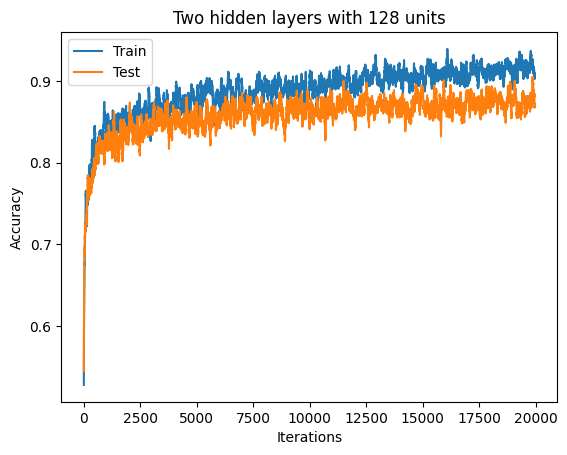

In [32]:
# Plot the accuracy curves
plt.plot(acc_two_hidden, label="Train")
plt.plot(test_acc_two_hidden, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Two hidden layers with 128 units")

Text(0.5, 1.0, 'Accuracy on Training Set')

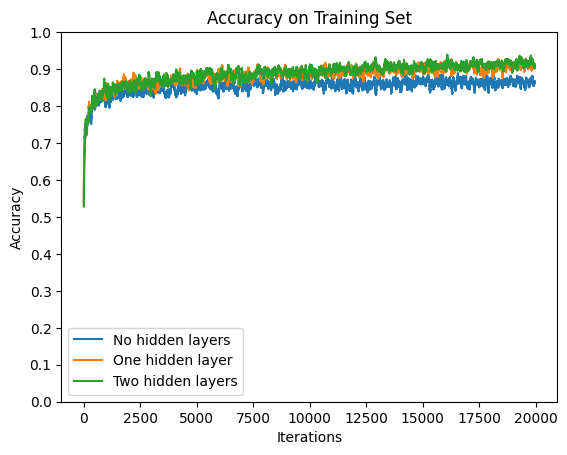

In [33]:
# Plot all of the mlp accuracy curves
plt.plot(acc_no_hidden, label="No hidden layers")
plt.plot(acc_one_hidden, label="One hidden layer")
plt.plot(acc_two_hidden, label="Two hidden layers")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.title("Accuracy on Training Set")

Text(0.5, 1.0, 'Accuracy on Test Set')

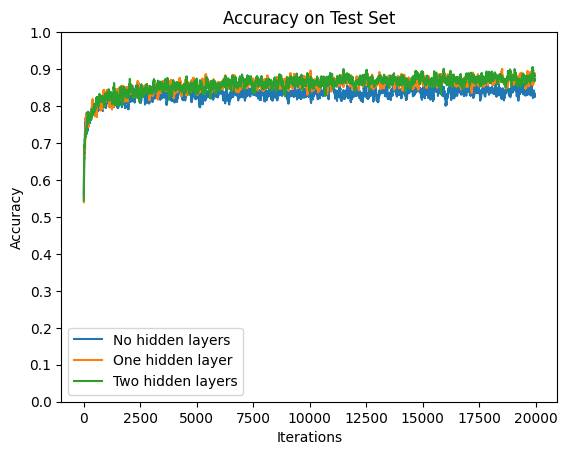

In [34]:
# Plot test accuracy curves
plt.plot(test_acc_no_hidden, label="No hidden layers")
plt.plot(test_acc_one_hidden, label="One hidden layer")
plt.plot(test_acc_two_hidden, label="Two hidden layers")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.title("Accuracy on Test Set")

In [35]:
# Pandas dataframe for final accuracy
data = {
    "No hidden layers": [final_acc_no_hidden],
    "One hidden layer": [final_acc_one_hidden],
    "Two hidden layers": [final_acc_two_hidden]
}
df = pd.DataFrame(data, index=["Final Testset Accuracy"])
df

,No hidden layers,One hidden layer,Two hidden layers
Final Testset Accuracy,0.8346,0.8756,0.8748


3. We now implement the last model of the previous section (two hidden layers) with a Leaky ReLU activation and with Logistic activation.

In [36]:
mlp_leaky_relu = MLP("LeakyReLU", 2, 128, len_img, 10, "kaiming")
mlp_leaky_relu.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                   0.01, batch_size=25, max_iters=MAX_ITERS)
acc_leaky_relu = smooth_plot(mlp_leaky_relu.acc_list, window_size=50)
test_acc_leaky_relu = smooth_plot(mlp_leaky_relu.test_acc_list, window_size=50)
testset_fashion_yh = mlp_leaky_relu.predict(testset_fashion_X)
final_acc_leaky_relu = mlp_leaky_relu.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Leaky ReLU')

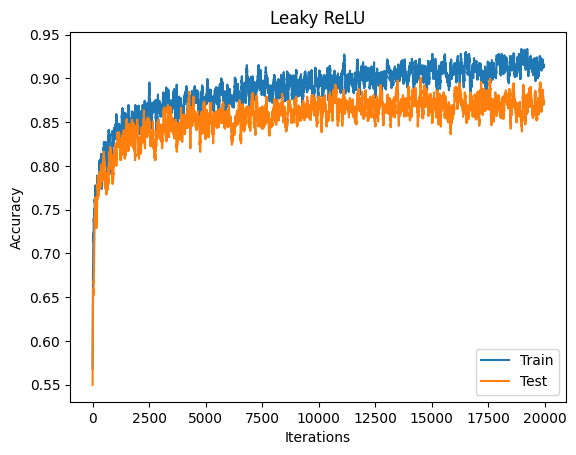

In [37]:
# Plot the accuracy curves
plt.plot(acc_leaky_relu, label="Train")
plt.plot(test_acc_leaky_relu, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Leaky ReLU")

In [38]:
# Use logistic activation
mlp_logistic = MLP("logistic", 2, 128, len_img, 10, "kaiming")
mlp_logistic.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
                0.01, batch_size=25, max_iters=MAX_ITERS)
acc_logistic = smooth_plot(mlp_logistic.acc_list, window_size=50)
test_acc_logistic = smooth_plot(mlp_logistic.test_acc_list, window_size=50)
testset_fashion_yh = mlp_logistic.predict(testset_fashion_X)
final_acc_logistic = mlp_logistic.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Logistic')

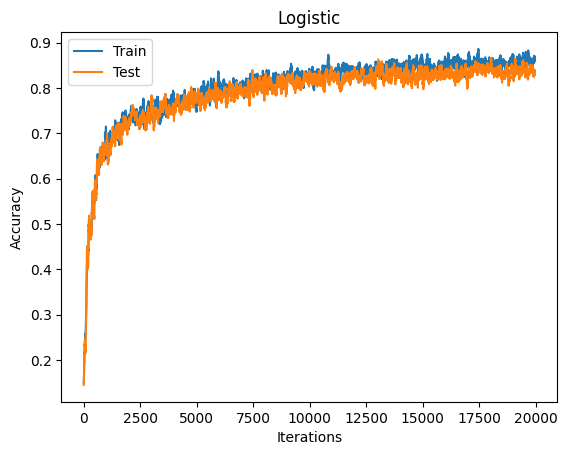

In [39]:
# Plot the accuracy curves
plt.plot(acc_logistic, label="Train")
plt.plot(test_acc_logistic, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Logistic")

In [40]:
# Use tanh activation
mlp_tanh = MLP("tanh", 2, 128, len_img, 10, "kaiming")
mlp_tanh.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
            0.01, batch_size=25, max_iters=MAX_ITERS)
acc_tanh = smooth_plot(mlp_tanh.acc_list, window_size=50)
test_acc_tanh = smooth_plot(mlp_tanh.test_acc_list, window_size=50)
testset_fashion_yh = mlp_tanh.predict(testset_fashion_X)
final_acc_tanh = mlp_tanh.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 20000


Text(0.5, 1.0, 'Tanh')

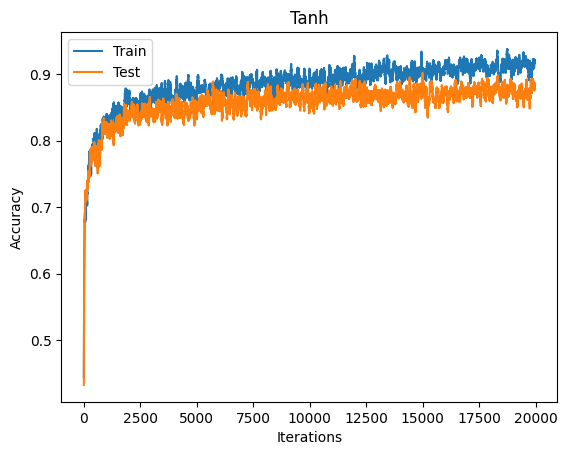

In [41]:
# Plot the accuracy curves
plt.plot(acc_tanh, label="Train")
plt.plot(test_acc_tanh, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Tanh")

Text(0.5, 1.0, 'Effect of different activation functions on training set')

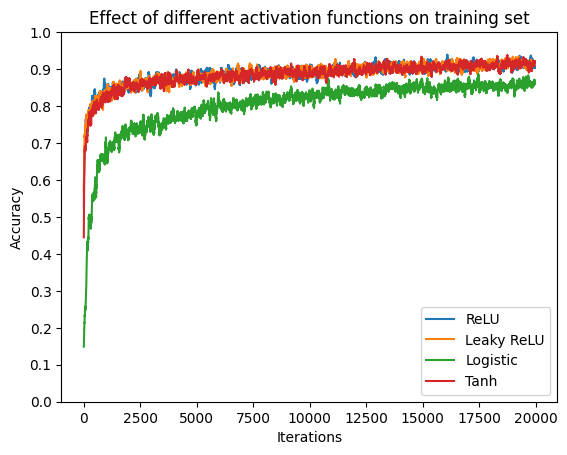

In [42]:
# Plot all of the mlp accuracy curves with 2 hidden layers
plt.plot(acc_two_hidden, label="ReLU")
plt.plot(acc_leaky_relu, label="Leaky ReLU")
plt.plot(acc_logistic, label="Logistic")
plt.plot(acc_tanh, label="Tanh")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.title("Effect of different activation functions on training set")

Text(0.5, 1.0, 'Effect of different activation functions on test set')

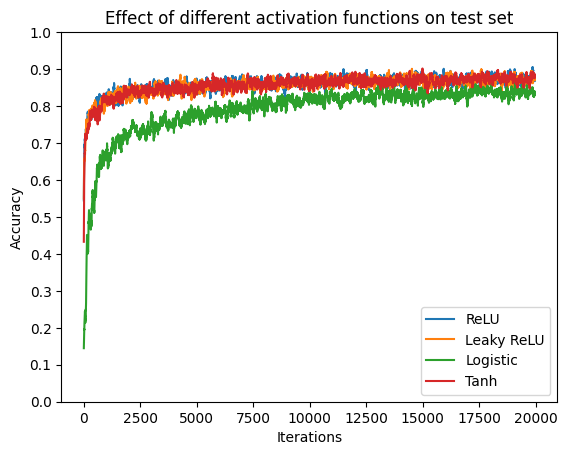

In [43]:
# Plot test accuracy curves
plt.plot(test_acc_two_hidden, label="ReLU")
plt.plot(test_acc_leaky_relu, label="Leaky ReLU")
plt.plot(test_acc_logistic, label="Logistic")
plt.plot(test_acc_tanh, label="Tanh")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.title("Effect of different activation functions on test set")

4. We now add L1 and L2 regularization to our MLP with 2 layers and ReLU activations. Since regularization is effective at reducing overfitting, we increase the number of training iterations to observe this.

In [44]:
MAX_ITERS = 50000

In [45]:
# 2 hidden layers with 128 neurons, no regularization
mlp_no_reg = MLP("ReLU", 2, 128, len_img, 10, "kaiming")
mlp_no_reg.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
               0.01, batch_size=25, max_iters=MAX_ITERS)
acc_no_reg = smooth_plot(mlp_no_reg.acc_list, window_size=50)
test_acc_no_reg = smooth_plot(mlp_no_reg.test_acc_list, window_size=50)
testset_fashion_yh = mlp_no_reg.predict(testset_fashion_X)
final_acc_no_reg = mlp_no_reg.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 50000


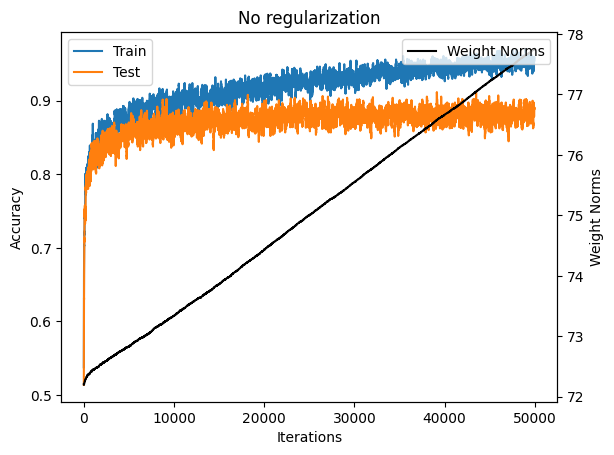

In [49]:
# Plot the accuracy curves, as well as weight norms on same scale
weight_norms_no_reg = mlp_no_reg.weight_norms
fig, ax1 = plt.subplots()
ax1.plot(acc_no_reg, label="Train")
ax1.plot(test_acc_no_reg, label="Test")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Accuracy")
ax1.set_title("No regularization")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot(weight_norms_no_reg, label="Weight Norms", color="black")
ax2.set_ylabel("Weight Norms")
ax2.legend(loc="upper right")


In [48]:
# 2 hidden layers with 128 neurons, L1 regularization
mlp_l1 = MLP("ReLU", 2, 128, len_img, 10, "kaiming")
mlp_l1.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
        0.01, batch_size=25, max_iters=MAX_ITERS, regularization="l1", lambda_=0.005)
acc_l1 = smooth_plot(mlp_l1.acc_list, window_size=50)
test_acc_l1 = smooth_plot(mlp_l1.test_acc_list, window_size=50)
testset_fashion_yh = mlp_l1.predict(testset_fashion_X)
final_acc_l1 = mlp_l1.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 50000


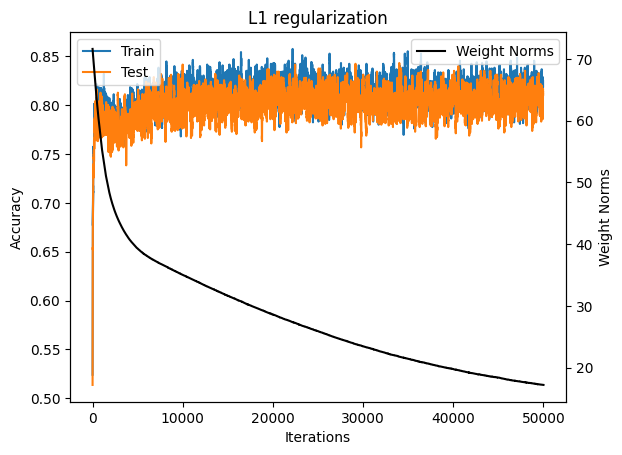

In [50]:
# Plot the accuracy curves, as well as weight norms on same scale
weight_norms_l1 = mlp_l1.weight_norms
fig, ax1 = plt.subplots()
ax1.plot(acc_l1, label="Train")
ax1.plot(test_acc_l1, label="Test")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Accuracy")
ax1.set_title("L1 regularization")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot(weight_norms_l1, label="Weight Norms", color="black")
ax2.set_ylabel("Weight Norms")
ax2.legend(loc="upper right")

In [51]:
# 2 hidden layers with 128 neurons, L2 regularization
mlp_l2 = MLP("ReLU", 2, 128, len_img, 10, "kaiming")
mlp_l2.fit(trainset_fashion_X, trainset_fashion_y, testset_fashion_X, testset_fashion_y,
           0.01, batch_size=25, max_iters=MAX_ITERS, regularization="l2", lambda_=0.005)
acc_l2 = smooth_plot(mlp_l2.acc_list, window_size=50)
test_acc_l2 = smooth_plot(mlp_l2.test_acc_list, window_size=50)
testset_fashion_yh = mlp_l2.predict(testset_fashion_X)
final_acc_l2 = mlp_l2.evaluate_acc(testset_fashion_y, testset_fashion_yh)

Finished in 50000


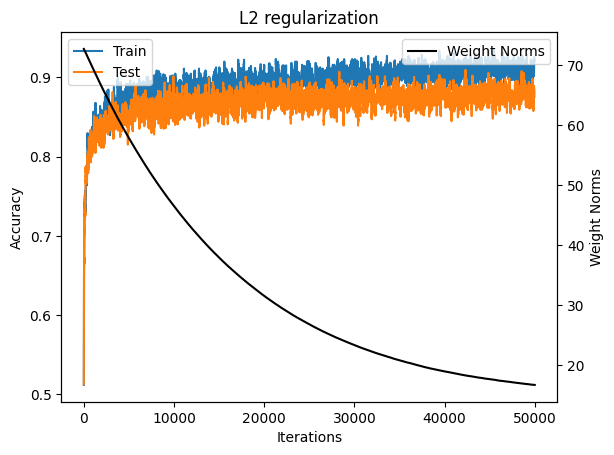

In [52]:
# Plot the accuracy curves, as well as weight norms on same scale
weight_norms_l2 = mlp_l2.weight_norms
fig, ax1 = plt.subplots()
ax1.plot(acc_l2, label="Train")
ax1.plot(test_acc_l2, label="Test")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Accuracy")
ax1.set_title("L2 regularization")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot(weight_norms_l2, label="Weight Norms", color="black")
ax2.set_ylabel("Weight Norms")
ax2.legend(loc="upper right")

Text(0.5, 1.0, 'Effect of regularization')

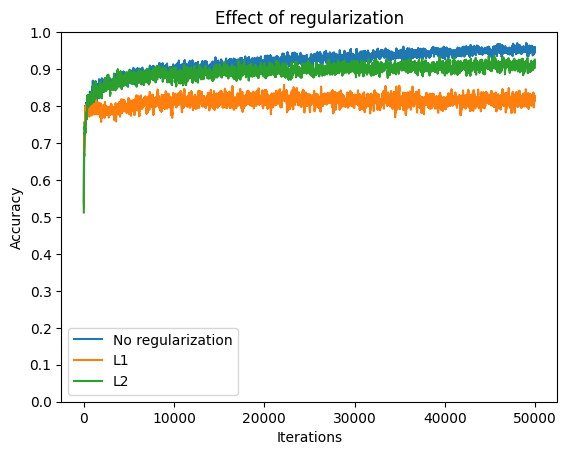

In [54]:
# Plot no regularization, L1, and L2 on same plot
plt.plot(acc_no_reg, label="No regularization")
plt.plot(acc_l1, label="L1")
plt.plot(acc_l2, label="L2")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.title("Effect of regularization on training set")

Text(0.5, 1.0, 'Effect of regularization on test set')

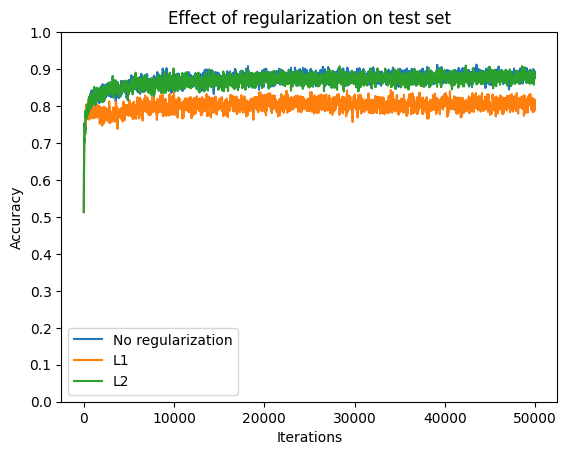

In [55]:
# Plot test accuracy curves
plt.plot(test_acc_no_reg, label="No regularization")
plt.plot(test_acc_l1, label="L1")
plt.plot(test_acc_l2, label="L2")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.title("Effect of regularization on test set")

Text(0.5, 1.0, 'Effect of regularization on weight norms')

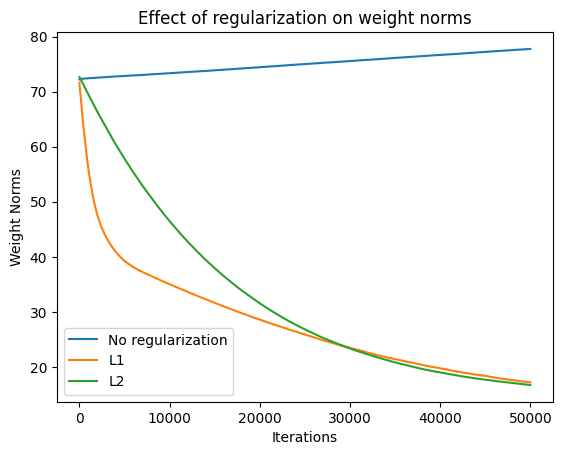

In [56]:
# Plot the weight norms for no regularization, L1, and L2 on same plot
plt.plot(weight_norms_no_reg, label="No regularization")
plt.plot(weight_norms_l1, label="L1")
plt.plot(weight_norms_l2, label="L2")
plt.xlabel("Iterations")
plt.ylabel("Weight Norms")
plt.legend()
plt.title("Effect of regularization on weight norms")

In [57]:
# Pandas dataframe for final accuracy
data = {
    "No regularization": [final_acc_no_reg],
    "L1": [final_acc_l1],
    "L2": [final_acc_l2]
}
df = pd.DataFrame(data, index=["Final Testset Accuracy"])
df

,No regularization,L1,L2
Final Testset Accuracy,0.8834,0.7979,0.8799


5. We now attempt to train with unnormalized images

In [58]:
MAX_ITERS = 10000

In [29]:
# Reverse normalization of fashion MNIST
trainset_fashion_X_unnorm = trainset_fashion_X * fashion_std + fashion_mean
testset_fashion_X_unnorm = testset_fashion_X * fashion_std + fashion_mean

In [34]:
# Train with Kaiming initialization
mlp_unnormalized = MLP("ReLU", 2, 128, len_img, 10, "kaiming")
mlp_unnormalized.fit(trainset_fashion_X_unnorm, trainset_fashion_y, 0.01, batch_size=25, max_iters=MAX_ITERS)

Finished in 10000


Text(0.5, 1.0, 'Unnormalized')

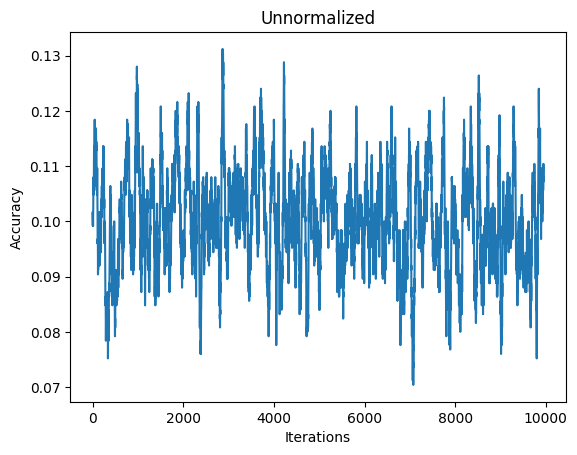

In [35]:
# Plot the accuracy curve
acc_unnormalized = smooth_plot(mlp_unnormalized.acc_list, window_size=50)
plt.plot(acc_unnormalized)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Unnormalized")

In [36]:
# Accuracy on test set
testset_fashion_yh = mlp_unnormalized.predict(testset_fashion_X_unnorm)
mlp_unnormalized.evaluate_acc(testset_fashion_y, testset_fashion_yh)

0.1

## Appendix: Tuning of Hyperparameters using SKLearn

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
# Question 1
fashion_mlp = MLPClassifier((128), max_iter=1000, random_state=seed)
parameters_grid = {"learning_rate_init": [0.01, 0.05, 0.1]}
grid_search = GridSearchCV(fashion_mlp, parameters_grid, scoring="accuracy")
grid_search.fit(trainset_fashion_X, trainset_fashion_y)

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=128, max_iter=1000,
                                     random_state=42),
             param_grid={'learning_rate_init': [0.01, 0.05, 0.1]},
             scoring='accuracy')

In [25]:
grid_search.best_params_

{'learning_rate_init': 0.01}